In [141]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.units as u
from datetime import datetime
from astropy.coordinates import SkyCoord
import pickle
import json
import sys
import os
import pandas as pd
from sys import getsizeof
pd.set_option('display.max_columns', None)

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/systematics/scripts"))
import auxiliar as aux
green = "#009736"
red = "#EE2A35"

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# dirs
objects_dir = "/fefs/aswg/workspace/juan.jimenez/systematics/objects"

# use from coordinates (use astropy units) or from name
target_ra  = None
target_dec = None
target_name = "Crab"

# select he number of off regions
n_off_regions = 3

# energy edges for spectrum
e_min = 80 * u.GeV
e_max = 20 * u.TeV

# energy edges for lightcurve
e_lc_min = 100 * u.GeV
e_lc_max = 20 * u.TeV

# intensity integration limits
intensity_integration_lims = [120, 160] #ph

In [142]:
%%time
###################
# reading objects
###################
# light curve data
with open(f'{objects_dir}/dict_LC.pkl', 'rb') as f:
    dict_LC = pickle.load(f)
dict_LC_2 = {}
for i, run in enumerate(np.array(dict_LC["run_number"]).astype(int)):
    tmp_dict = {
        "flux" : dict_LC["flux"][i], 
        "e_flux" : dict_LC["e_flux"][i], 
        "timestamp" : dict_LC["timestamp"][i], 
        "duration" : dict_LC["duration"][i], 
        "zd" : dict_LC["zd"][i],
        "az" : dict_LC["az"][i]
    }
    dict_LC_2[run] = tmp_dict
    
# l2 to dl3 information
with open(f"{objects_dir}/total_dict_runs.json", "r") as json_file:
    dict_dl2todl3 = json.load(json_file)
    
# load dl2 desired data
with open('objects/dict_dl2.pkl', 'rb') as f:
    dict_dl2 = pickle.load(f)

CPU times: user 1.4 s, sys: 29.1 s, total: 30.5 s
Wall time: 3min 36s


### Bulk of data, without adjustments

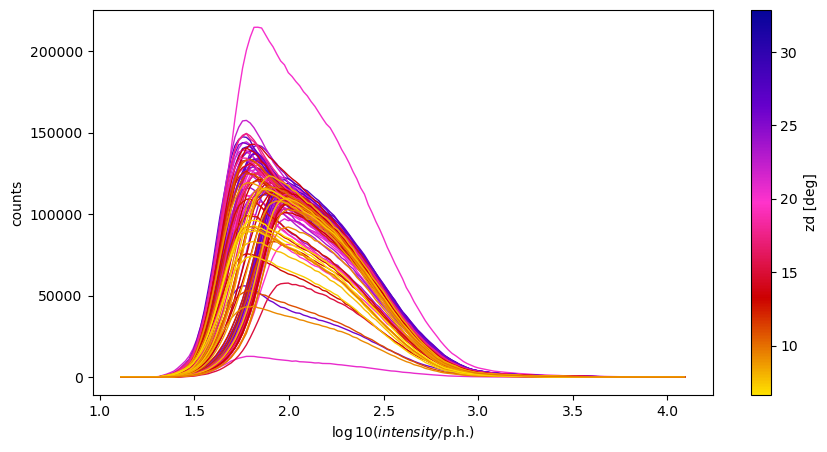

In [143]:
fig, ax = plt.subplots(figsize=(10, 5))


keys = dict_dl2.keys()
bins = np.linspace(1.1, 4.1, 150)

for run in [_ for _ in dict_dl2.keys()][:]:  
    
    # getting the color of each run
    meanzd = np.mean(dict_dl2[run]["zd"])
    X = np.abs(meanzd - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    ax.plot(Icenters, counts, color=color, lw=1) # drawstyle='steps-mid'

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

ax.set_xlabel("$\log10(intensity/$p.h.$)$")
ax.set_ylabel("counts")
plt.show()

### Time correction

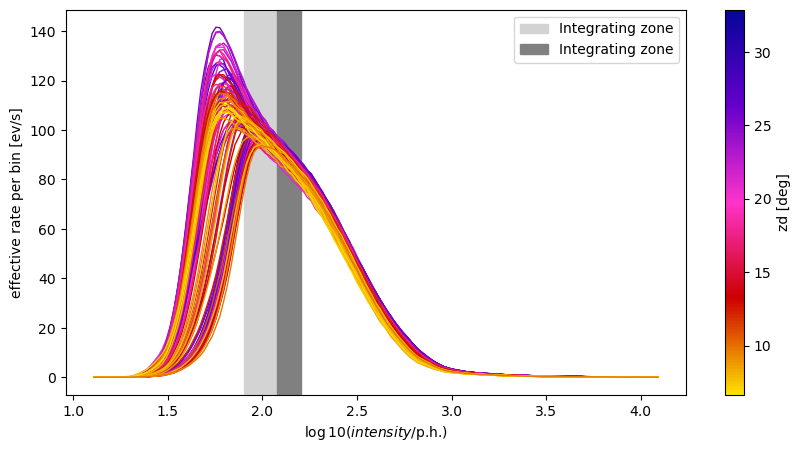

In [144]:
fig, ax = plt.subplots(figsize=(10, 5))

keys = dict_dl2.keys()
bins = np.linspace(1.1, 4.1, 150) 

for run in [_ for _ in dict_dl2.keys()][:]:  
    
    # getting the color of each run
    meanzd = np.mean(dict_dl2[run]["zd"])
    X = np.abs(meanzd - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    counts   = counts / dict_dl2[run]["effective_time"]
    
    integral = 0
    for i, b in enumerate(bins[:-1]):
        if bins[i] > np.log10(intensity_integration_lims[0]) and bins[i+1] < np.log10(intensity_integration_lims[1]):
            integral = integral + counts[i]
    
    dict_dl2[run]["counts_80_120_ph"] = integral
    
    ax.plot(Icenters, counts, color=color, lw=1)

# run = 3615 
# counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
# Icenters = (Iedges[1:] + Iedges[:-1]) / 2
# ax.plot(Icenters, counts / dict_dl2[run]["effective_time"], color="k", zorder=10000, lw=4, label=f"Run {run}")

ax.axvspan(np.log10(intensity_integration_lims[0]-40), np.log10(intensity_integration_lims[1]-40), color="lightgray", label="Integrating zone")
ax.axvspan(np.log10(intensity_integration_lims[0]), np.log10(intensity_integration_lims[1]), color="gray", label="Integrating zone")

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

ax.legend()
ax.set_xlabel("$\log10(intensity/$p.h.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
plt.show()

In [145]:
counts_80_120 = []
crabflux      = []
e_crabflux    = []
zd, az        = [], []

for run in dict_dl2.keys():
    counts_80_120.append(dict_dl2[run]["counts_80_120_ph"])
    crabflux.append(dict_LC_2[run]["flux"].value)
    e_crabflux.append(dict_LC_2[run]["e_flux"].value)
    zd.append(dict_LC_2[run]["zd"].value)
    az.append(dict_LC_2[run]["az"].value)

counts_80_120 = np.array(counts_80_120)
crabflux = np.array(crabflux)
e_crabflux = np.array(e_crabflux)
zd = np.array(zd)
az = np.array(az)

### Some distributions

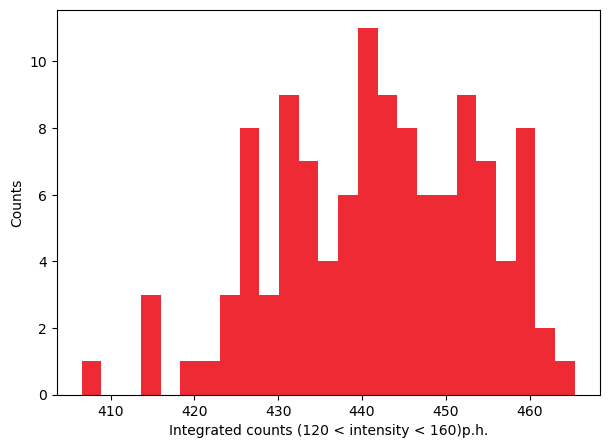

In [146]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(counts_80_120, 25, color=red)

ax.set_ylabel("Counts")
ax.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
plt.show()

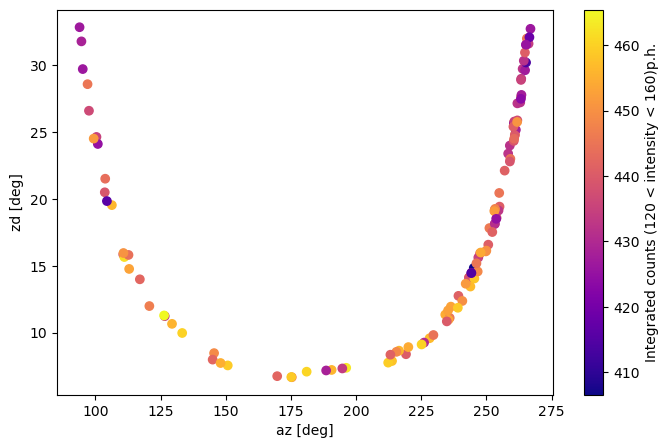

In [147]:
fig, ax = plt.subplots(figsize=(8, 5))
sc = ax.scatter(az, zd, c=counts_80_120, cmap="plasma")
fig.colorbar(sc, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")

ax.set_xlabel("az [deg]")
ax.set_ylabel("zd [deg]")
plt.show()

### Linearly fitting the zd to the counts

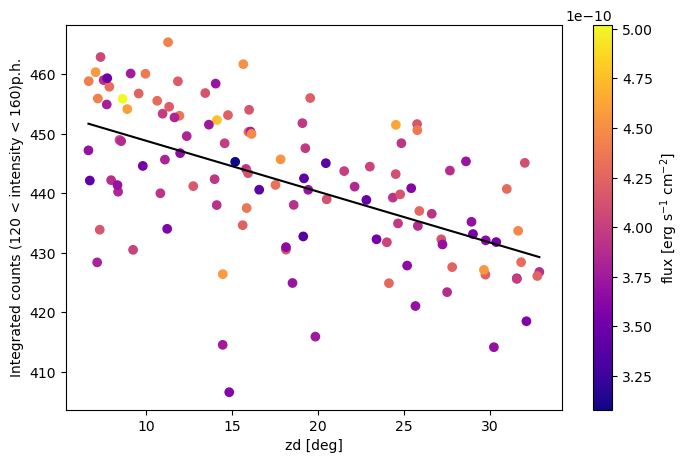

In [155]:
# Perform linear fit
fit = np.polyfit(zd, counts_80_120, 1)
fit_fn = np.poly1d(fit)

line_values = fit_fn(zd)
ratio = line_values/counts_80_120
for i, run in enumerate(dict_dl2.keys()):
    dict_LC_2[run]["zd_correction"] = fit_fn(dict_LC_2[run]["zd"].value) / dict_dl2[run]["counts_80_120_ph"]

fig, ax = plt.subplots(figsize=(8, 5))
sc = ax.scatter(zd, counts_80_120, c=crabflux, cmap="plasma")
# ax.scatter(zd, counts_80_120*ratio, color="lightgray", zorder=-10)

fig.colorbar(sc, label="flux [erg s${}^{-1}$ cm${}^{-2}$]")

x_array = np.linspace(min(zd), max(zd), 200)
plt.plot(x_array, fit_fn(x_array), '-k', label="Linear Fit")

ax.set_ylabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax.set_xlabel("zd [deg]")
plt.show()

### Applying zd corrections

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


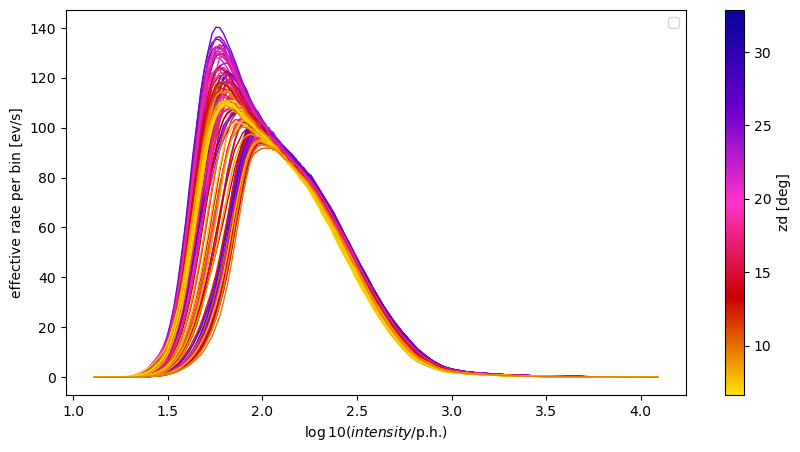

In [149]:
fig, ax = plt.subplots(figsize=(10, 5))

keys = dict_dl2.keys()
bins = np.linspace(1.1, 4.1, 150) 

for run in [_ for _ in dict_dl2.keys()][:]:  
    
    # getting the color of each run
    meanzd = np.mean(dict_dl2[run]["zd"])
    X = np.abs(meanzd - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    counts   = counts / dict_dl2[run]["effective_time"] * dict_LC_2[run]["zd_correction"]
    
    ax.plot(Icenters, counts, color=color, lw=1)

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

ax.legend()
ax.set_xlabel("$\log10(intensity/$p.h.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
plt.show()

In [150]:
crabflux_zdcorr = []
counts_zcorr = []
for run in dict_dl2.keys():
    crabflux_zdcorr.append(dict_LC_2[run]["flux"].value *  dict_LC_2[run]["zd_correction"])
    counts_zcorr.append(dict_dl2[run]["counts_80_120_ph"] *  dict_LC_2[run]["zd_correction"])

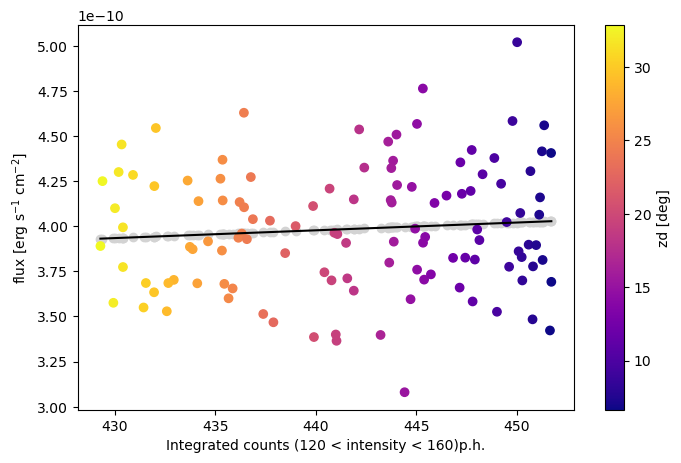

In [151]:
# Perform linear fit
fit = np.polyfit(counts_zcorr, crabflux, 1)
fit_fn = np.poly1d(fit)

line_values = fit_fn(counts_zcorr)
ratio = line_values/crabflux
for i, run in enumerate(dict_dl2.keys()):
    dict_LC_2[run]["c_correction"] = fit_fn(dict_dl2[run]["counts_80_120_ph"]) / (dict_LC_2[run]["flux"].value * dict_LC_2[run]["zd_correction"])
    
fig, ax = plt.subplots(figsize=(8, 5))
sc = ax.scatter(counts_zcorr, crabflux, c=zd, cmap="plasma")
fig.colorbar(sc, label="zd [deg]")
ax.scatter(counts_zcorr, crabflux*ratio, color="lightgray", zorder=-10)

x_array = np.linspace(min(counts_zcorr), max(counts_zcorr), 200)
plt.plot(x_array, fit_fn(x_array), '-k', label="Linear Fit")

ax.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
plt.show()

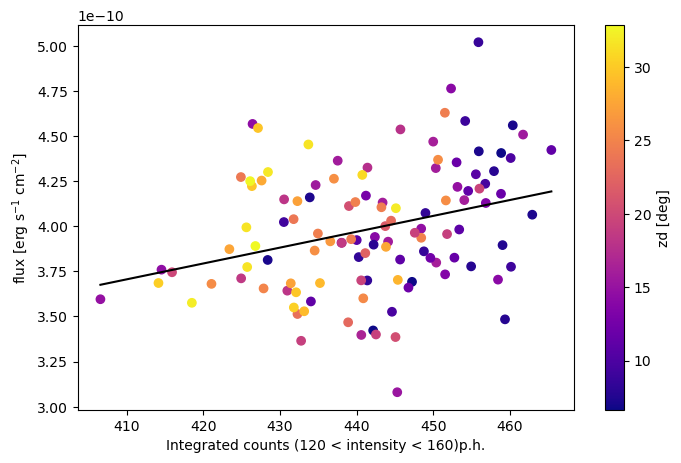

In [152]:
# Perform linear fit
fit = np.polyfit(counts_80_120, crabflux, 1)
fit_fn = np.poly1d(fit)

line_values = fit_fn(counts_80_120)
ratio = line_values/crabflux
for i, run in enumerate(dict_dl2.keys()):
    dict_LC_2[run]["c_correction"] = fit_fn(dict_dl2[run]["counts_80_120_ph"]) / (dict_LC_2[run]["flux"].value)
    
fig, ax = plt.subplots(figsize=(8, 5))
sc = ax.scatter(counts_80_120, crabflux, c=zd, cmap="plasma")
fig.colorbar(sc, label="zd [deg]")
# ax.scatter(counts_80_120, crabflux*ratio, color="lightgray", zorder=-10)

x_array = np.linspace(min(counts_80_120), max(counts_80_120), 200)
plt.plot(x_array, fit_fn(x_array), '-k', label="Linear Fit")

ax.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
plt.show()

In [153]:
crabflux_ccorr = []
for run in dict_dl2.keys():
    crabflux_ccorr.append(dict_LC_2[run]["flux"].value *  dict_LC_2[run]["c_correction"])

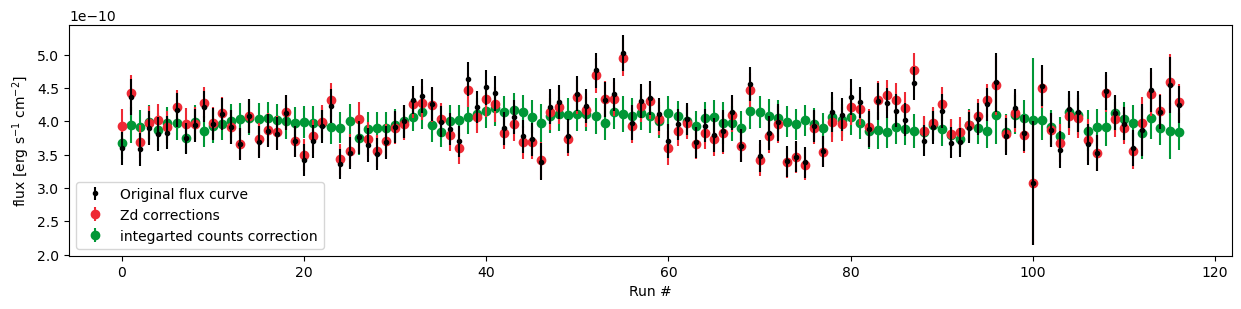

In [154]:

    
fig, ax = plt.subplots(figsize=(15, 3))

for i, run in enumerate(dict_LC_2.keys()):  

    if i == 0:
        ax.errorbar([i], [dict_LC_2[run]["flux"].value], yerr=dict_LC_2[run]["e_flux"].value, marker=".", ls="", color="k", label="Original flux curve")

        ax.errorbar([i], [dict_LC_2[run]["flux"].value * dict_LC_2[run]["zd_correction"]], yerr=dict_LC_2[run]["e_flux"].value, marker="o", ls="", color=red, zorder=0, 
                   label="Zd corrections")
        ax.errorbar([i], [dict_LC_2[run]["flux"].value * dict_LC_2[run]["c_correction"]], yerr=dict_LC_2[run]["e_flux"].value, marker="o", ls="", color=green, zorder=-1,
                   label="integarted counts correction")
    else:    
        ax.errorbar([i], [dict_LC_2[run]["flux"].value], yerr=dict_LC_2[run]["e_flux"].value, marker=".", ls="", color="k", )

        ax.errorbar([i], [dict_LC_2[run]["flux"].value * dict_LC_2[run]["zd_correction"]], yerr=dict_LC_2[run]["e_flux"].value, marker="o", ls="", color=red, zorder=0)
        ax.errorbar([i], [dict_LC_2[run]["flux"].value * dict_LC_2[run]["c_correction"]], yerr=dict_LC_2[run]["e_flux"].value, marker="o", ls="", color=green, zorder=-1)

ax.legend()
ax.set_xlabel(f"Run #")
ax.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
plt.show()

In [94]:
sigma, sigma_zdcorr, sigma_ccorr = np.std(crabflux), np.std(crabflux_zdcorr), np.std(crabflux_ccorr)

In [123]:
np.mean(crabflux), np.mean(crabflux_zdcorr), np.mean(crabflux_ccorr)

(3.985591107335674e-10, 3.9852013902560666e-10, 3.9855911073356743e-10)

In [124]:
np.std(crabflux), np.std(crabflux_zdcorr), np.std(crabflux_ccorr)

(3.4138248120056175e-11, 3.236860814234492e-11, 1.0646439851323796e-11)

In [95]:
(sigma - sigma_zdcorr)/ sigma * 100, (sigma - sigma_ccorr)/ sigma * 100

(5.1837457255798425, 60.17469064814234)